In [25]:
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVBeam
import healpy as hp
from scipy.signal import deconvolve
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter

In [26]:
def gaussian(x,m,std):
    return 1.0 / np.sqrt(2*np.pi*std**2) * np.exp(-(x-m)**2 / (2*std**2))

In [27]:
x = np.linspace(0, 1, 200)
y = gaussian(x, 0.5, 0.05)
y2 = gaussian(x, 0.5, 0.1)

Widen a gaussian

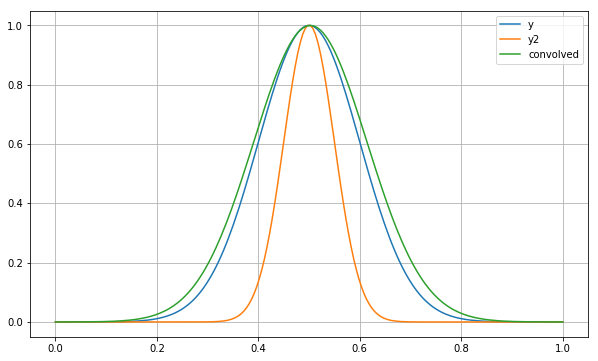

In [28]:
plt.figure(figsize=(10,6))
plt.plot(x,y2 / y2.max(), label='y')
plt.plot(x,y / y.max(), label='y2')
plt.plot(x, np.convolve(y, y2, mode='same') / np.convolve(y, y2, mode='same').max(), label='convolved')
plt.legend()
plt.grid()
plt.show()

Narrow a gaussian

## Widening the Beam

In [29]:
def hera_beam_freq_slice(hera_beam, freq, beam_center = 90, ang_from_center = 15, n = 100):
    '''
    Returns a beam cut at a defined frequency
    
    Parameters
    ----------
    hera_beam : UVBeam
        HERA beam model simulation read into a UVBeam object
    freq: int
        Frequency to pull from simulation
    beam_center: float, optional
        Zenith declination, set to 90 degrees in the simulation
    ang_from_center: int
        Angle from zenith to map the simulated beam out to
    n: int
        Number of points in the plot 
    
    Returns
    -------
    ang : array-like
        Angle from zenith for each point in the beam model
    beam_slice: array-like
        Beam model at the given frequency and angle range
    
    '''
    ang = np.linspace(beam_center-ang_from_center,beam_center+ang_from_center,n)
    beam_slice     = []
    beam_map       = hera_beam[:,freq-50]
    beam_map_norm  = beam_map/np.max(beam_map) 
    
    for i in ang:
        beam_slice.append(hp.get_interp_val(beam_map_norm, 0, i, lonlat=True))  
    
    return ang, np.array(beam_slice)

In [30]:
hera_beam_file = '/Users/tyler/Desktop/Research/Tsys/data/HERA_beam_nic.hmap'
hera_im = fits.getdata(hera_beam_file, extname='BEAM_{0}'.format('X'))
nside = hp.npix2nside(hera_im.shape[0])
temp_f = fits.getdata(hera_beam_file, extname='FREQS_{0}'.format('X'))

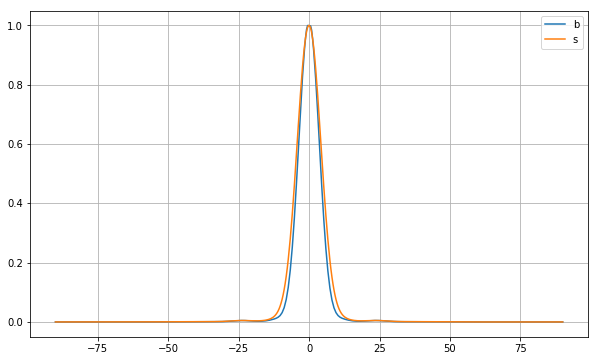

In [31]:
std = 2.5
std1 = 1
ang, beam = hera_beam_freq_slice(hera_im, 200, ang_from_center=90, n=500)
y = gaussian(ang-90, 0, std)
conv_beam = np.convolve(beam, 1.0/y, mode='same') / np.convolve(beam,1.0/y, mode='same').max()

np.random.seed(1)
deg = np.abs(ang.shape[0]/2.0-np.argmin(np.abs((ang-90)-std)))
deg2 = np.abs(ang.shape[0]/2.0-np.argmin(np.abs((ang-90)-std1)))

smooth = gaussian_filter(beam, deg)
squigg = smooth+smooth*np.random.uniform(-0.2, 0.2, smooth.shape[0])
smooth_squigg = gaussian_filter(squigg, deg2)

w_noise = beam+gaussian_filter(beam*np.random.uniform(-0.25, 0.25, beam.shape[0]), deg2)

plt.figure(figsize=(10,6))
plt.plot(ang-90, beam, label='b')
#plt.plot(ang-90, conv_beam, label='c')
plt.plot(ang-90, smooth/smooth.max(), label='s')
#plt.plot(ang-90, 10.0**(smooth/10.0), label='s')
plt.legend()
plt.grid()
plt.show()

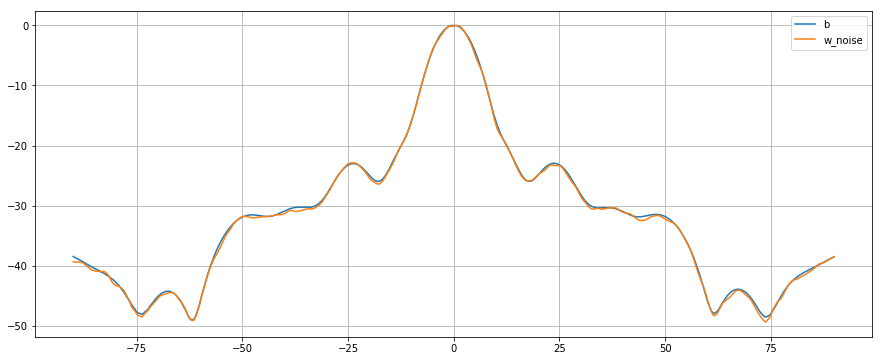

In [21]:
plt.figure(figsize=(15,6))
plt.plot(ang-90, 10*np.log10(beam), label='b')
plt.plot(ang-90, 10*np.log10(w_noise/w_noise.max()), label='w_noise')
plt.legend()

plt.grid()
plt.show()

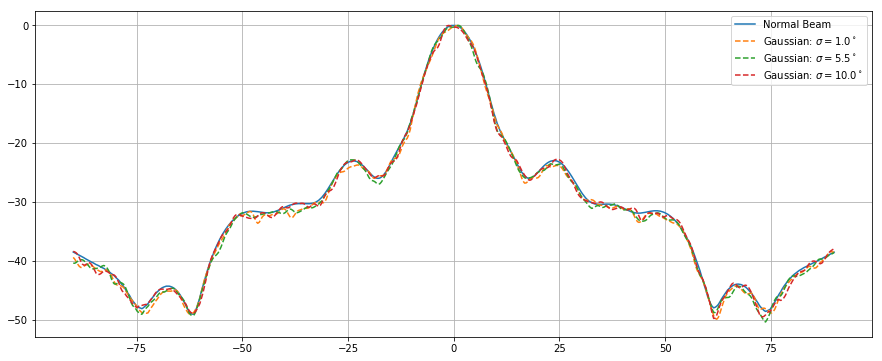

In [39]:
ang, beam = hera_beam_freq_slice(hera_im, 200, ang_from_center=90, n=500)
np.random.seed(1)

plt.figure(figsize=(15,6))

plt.plot(ang-90, 10*np.log10(beam), label='Normal Beam')

for std in np.linspace(1, 10, 3):
    deg2 = np.abs(ang.shape[0]/2.0-np.argmin(np.abs((ang-90)-std1)))
    smooth = beam+gaussian_filter(beam*np.random.uniform(-0.5, 0.5, beam.shape[0]), deg2)
    plt.plot(ang-90, 10*np.log10(smooth/smooth.max()), linestyle='--',label='Gaussian: $\sigma = ${}$^\circ$'.format(std))
plt.legend()
plt.grid()
plt.show()

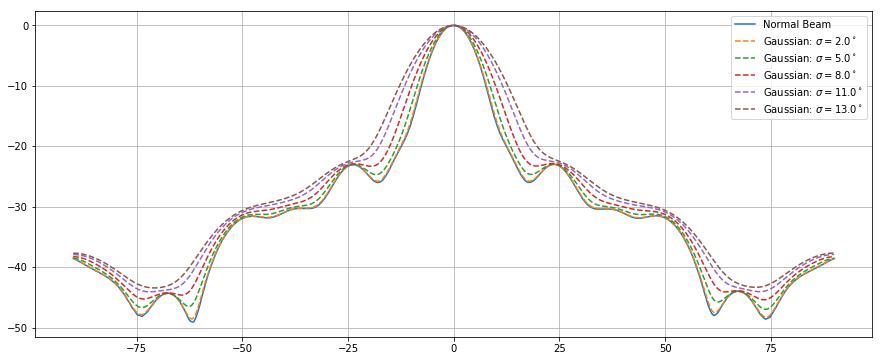

In [18]:
ang, beam = hera_beam_freq_slice(hera_im, 200, ang_from_center=20, n=500)
np.random.seed(1)

plt.figure(figsize=(15,6))

plt.plot(ang-90, 10*np.log10(beam), label='Normal Beam')

for std in np.linspace(1, 5, 5):
    deg = np.abs(ang.shape[0]/2.0-np.argmin(np.abs((ang-90)-std)))
    smooth = gaussian_filter(beam, deg)
    plt.plot(ang-90, 10*np.log10(smooth/smooth.max()), linestyle='--',label='Gaussian: $\sigma = ${}$^\circ$'.format(deg))
plt.legend()
plt.grid()
plt.show()

Sigma is 297.814834 arcmin (0.086631 rad) 
-> fwhm is 701.300341 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


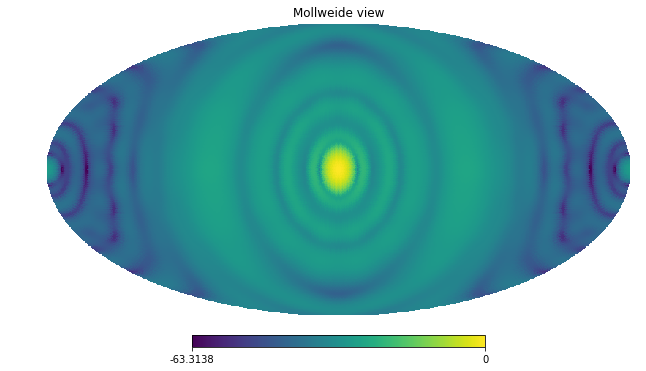

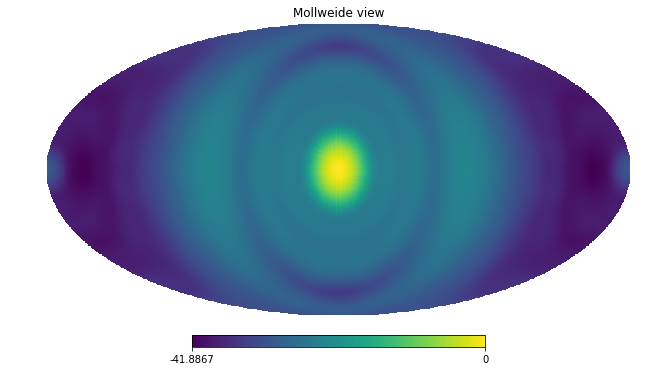

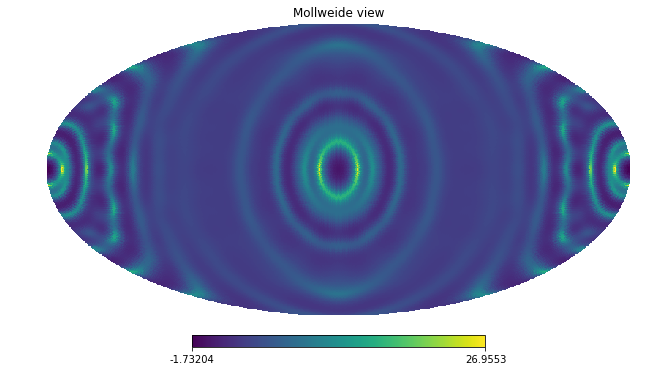

In [412]:
deg = 5

sig_to_fwhm = 2.4

smoothed_beam = hp.sphtfunc.smoothing(hera_im[:,100], fwhm=deg*0.017*sig_to_fwhm)
hp.mollview(10*np.log10(hera_im[:,100]), rot=[0,90])
hp.mollview(10*np.log10(smoothed_beam/smoothed_beam.max()), rot=[0,90])
hp.mollview(10*np.log10(smoothed_beam/smoothed_beam.max())-10*np.log10(hera_im[:,100]), rot=[0,90])

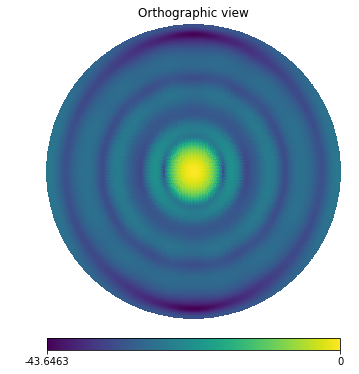

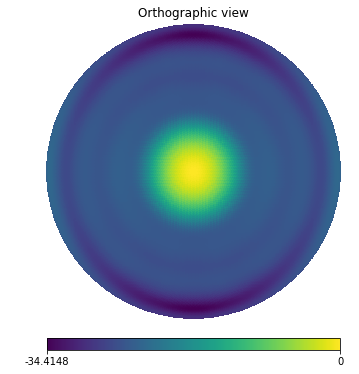

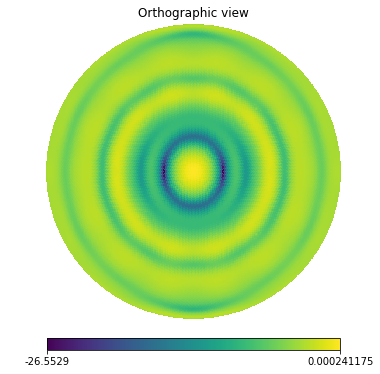

In [413]:
hp.orthview(10*np.log10(hera_im[:,100]), rot=[0,90], return_projected_map=False, half_sky=True)
hp.orthview(10*np.log10(smoothed_beam/smoothed_beam.max()), rot=[0,90], return_projected_map=False, half_sky=True)
diff_beam = hp.orthview(10*np.log10(hera_im[:,100])-10*np.log10(smoothed_beam/smoothed_beam.max()), rot=[0,90], return_projected_map=True, half_sky=True)